# Surviving Survival Analysis - I

# by

# Papers, Thoughts and Research Insights (PaTaRI)    -- TIA Centre

The objective of this notebook is to provide a step-by-step description and implementation on how to perform survival analysis using time the event take to occur and other variables (features). From this notebook, you can learn

(1) how to use Kaplan-Meier curve to estimate survival curves.

(2) how to use Nelson-Aalen curve to visualise the cumulative hazard.

(3) how to use Log-rank test to compare the survival distributions of two groups, how to calculate p-value

(4) how to use Cox proportional hazards model to investigate the association between the survival time of patients and one or more predictor variables; how to calculate c-index, hazard ratio...

(5) how to use regression coefficients of the fitted Cox models to predict the risk score which can be used as a new feature for patient stratification

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Loading Data

In [ ]:
# Load the dataset into a Pandas dataframe
import os
import pandas as pd
data_dir = os.path.join('/content', 'gdrive', 'My Drive', 'Colab Notebooks', 'survival_analysis')
dataset_path = os.path.join(data_dir, 'example_dataset.csv')
dataset = pd.read_csv(dataset_path)

In [ ]:
dataset

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,time,event
0,1.475876,-1.776096,4.915642,122.0,98.094698,5.972386,1.660803,-1.864064,118.0,7.660347,0.000000,0.0
1,6.962669,-1.252591,19.444990,111.0,-8.769640,8.096565,23.921275,-0.451359,131.0,-1.836969,0.000000,0.0
2,4.974584,-1.443488,-2.923769,109.0,69.898629,5.883239,11.301937,-3.209809,132.0,0.825555,2.149633,1.0
3,6.565848,-0.209302,15.752279,118.0,-9.126213,7.206371,15.295552,-1.707323,117.0,2.551161,1.311286,1.0
4,8.185607,0.997027,8.567676,119.0,24.094598,7.853565,12.516080,-0.047749,127.0,6.001835,0.215496,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,5.740516,0.687209,13.657878,110.0,76.031360,2.031302,17.613828,-0.716146,123.0,0.553241,0.000000,0.0
996,1.637833,-0.224637,22.426366,121.0,69.115131,7.563708,11.802899,-0.311101,107.0,5.578604,0.000000,0.0
997,6.441727,-1.003687,0.796903,129.0,47.684423,7.378485,9.815511,-2.160617,128.0,8.668370,0.000000,0.0
998,6.669404,0.326433,18.004485,121.0,-14.890240,-0.599931,6.783380,-3.588625,123.0,5.390423,1.893789,1.0


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x_1     1000 non-null   float64
 1   x_2     1000 non-null   float64
 2   x_3     1000 non-null   float64
 3   x_4     1000 non-null   float64
 4   x_5     1000 non-null   float64
 5   x_6     1000 non-null   float64
 6   x_7     1000 non-null   float64
 7   x_8     1000 non-null   float64
 8   x_9     1000 non-null   float64
 9   x_10    1000 non-null   float64
 10  time    1000 non-null   float64
 11  event   1000 non-null   float64
dtypes: float64(12)
memory usage: 93.9 KB


# Handle Categorical Variables

If the categorical values are ordinal, meaning you can place them in some kind of order (e.g. "Low", "Intermediate", and "High"), you can convert these into ordered numeric values where Low = 0, Intermediate = 1, and High = 2. 

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

If the values are not ordinal, meaning the order of them doesn't matter (e.g. "Positive", "Negative") then you can use one-hot encoding (only 0 or 1)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()

# Use Kaplan Meier Curve to estimate survival function

In [ ]:
!pip install lifelines 

     |████████████████████████████████| 358kB 5.2MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp37-none-any.whl size=4050 sha256=b647b72838b4e1ce6a1676a90021bc885772418be74ec77721e8fb910303dd89
  Stored in directory: /root/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854f5be70d41912b8f886f908bb
Successfully built autograd-gamma


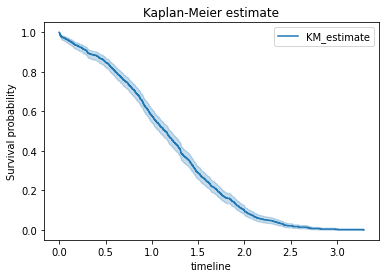

In [ ]:
# Importing modules
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
# Initializing the KaplanMeierModel
km_model = KaplanMeierFitter()

# Fitting the model 
T = dataset['time'].values
E = dataset['event'].values
km_model.fit(T, event_observed=E)

# Plot the graph
km_model.plot()
plt.title('Kaplan-Meier estimate')
plt.ylabel('Survival probability')
plt.show()

In [ ]:
# Give a summary of the life table
km_model.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.000000,156,0,156,1000,1000
0.000118,1,1,0,0,844
0.000119,1,1,0,0,843
0.000556,1,1,0,0,842
0.001176,1,1,0,0,841
...,...,...,...,...,...
2.808289,1,1,0,0,5
2.825555,1,1,0,0,4
2.980501,1,1,0,0,3


In [ ]:
# Survival probability
km_model.survival_function_

,KM_estimate
timeline,
0.000000,1.000000
0.000118,0.998815
0.000119,0.997630
0.000556,0.996445
0.001176,0.995261
...,...
2.808289,0.005606
2.825555,0.004205
2.980501,0.002803


In [ ]:
# Report how uncertain the survival propability at each event happens
km_model.confidence_interval_

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.000000,1.000000,1.000000
0.000118,0.991619,0.999833
0.000119,0.990559,0.999407
0.000556,0.989020,0.998852
0.001176,0.987422,0.998219
...,...,...
2.808289,0.001915,0.013648
2.825555,0.001201,0.011655
2.980501,0.000589,0.009614
3.008720,0.000143,0.007620


In [ ]:
# Number of time (days) where on average 50% patients survive
km_model.median_survival_time_

1.143319613808461

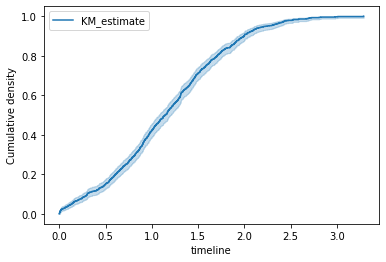

In [ ]:
# Probability of death
# As the number of survival days increases, the probability of a person dying increases.
km_model.plot_cumulative_density()
plt.ylabel('Cumulative density')
plt.show()

# Use Nelson-Aalen curve to visualize the cumulative hazard

          NA_estimate
timeline             
0.000000     0.000000
0.000118     0.001185
0.000119     0.002371
0.000556     0.003559
0.001176     0.004748
...               ...
2.808289     5.065011
2.825555     5.315011
2.980501     5.648345
3.008720     6.148345
3.290219     7.148345

[845 rows x 1 columns]


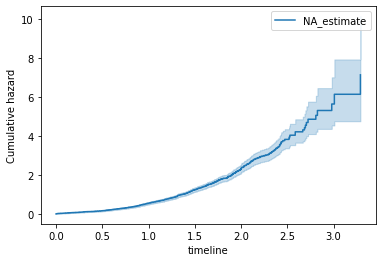

In [ ]:
# Hazard Function :
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()
naf.fit(T, event_observed=E)
print (naf.cumulative_hazard_)
naf.plot()
plt.ylabel('Cumulative hazard')
plt.show()

In [ ]:
# We can predict the value of a certain point :
print (naf.predict(2))

2.303927914715109


# Use Log-rank test to compare the survival distributions of two groups

In [ ]:
dataset.describe()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,time,event
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,3.933096,-0.019020,10.215942,119.901000,40.184830,4.141882,10.721999,0.001848,119.940000,3.939589,0.935612,0.777000
std,3.503540,1.525172,10.158179,6.998155,34.889940,3.507425,9.812646,1.382300,6.976609,3.387771,0.698505,0.416467
min,-1.994536,-6.493502,-20.248903,97.000000,-19.762374,-1.999779,-26.430794,-4.873261,97.000000,-1.993070,0.000000,0.000000
25%,0.908900,-0.737527,3.882703,115.000000,9.953714,1.039198,4.240241,-0.633385,115.000000,1.060815,0.303683,1.000000
50%,3.865738,-0.004258,10.012378,120.000000,41.658891,4.259585,10.467832,-0.024329,120.000000,3.955468,0.913473,1.000000
75%,6.928082,0.718291,16.609590,125.000000,69.693247,7.257454,17.254294,0.701226,125.000000,6.795205,1.433173,1.000000
max,9.989079,6.798176,41.956827,141.000000,99.878336,9.957083,47.415239,8.900891,140.000000,9.994411,3.290219,1.000000


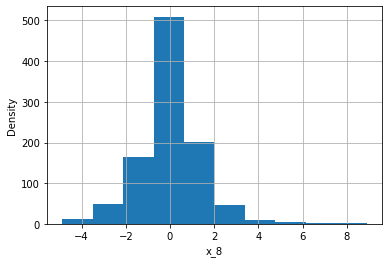

In [ ]:
# Data distribution using histogram
dataset['x_8'].hist()
plt.xlabel('x_8')
plt.ylabel('Density')
plt.show()

In [ ]:
# check is there any significant difference in survival rate when consider one feature
# Here we take feature x_8 as an example and take the mean as the cut-off value 
import numpy as np
cutoff_value = np.mean(dataset['x_8'])
# Divide data into groups
upper = dataset['x_8']>cutoff_value
T_upper = dataset['time'][upper]
E_upper = dataset['event'][upper]

In [ ]:
lower = dataset['x_8']<=cutoff_value
T_lower = dataset['time'][lower]
E_lower = dataset['event'][lower]

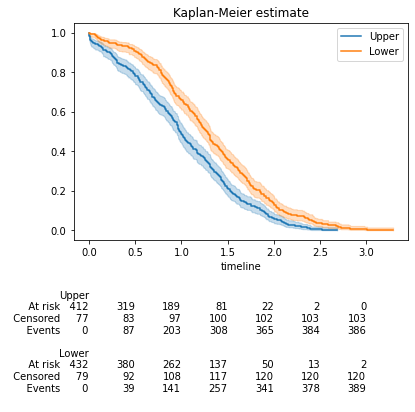

<Figure size 432x288 with 0 Axes>

In [ ]:
# Initializing the KaplanMeierModel for each group
km_upper = KaplanMeierFitter()
km_lower = KaplanMeierFitter()

# Fitting the model 
T = dataset['time'].values
E = dataset['event'].values
ax = plt.subplot(111)
ax = km_upper.fit(T_upper, event_observed=E_upper, label = 'Upper').plot_survival_function(ax=ax)
ax = km_lower.fit(T_lower, event_observed=E_lower, label = 'Lower').plot_survival_function(ax=ax)

# Plot the graph
# km_upper.plot()
# km_lower.plot()


from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(km_upper, km_lower, ax=ax)
plt.title('Kaplan-Meier estimate')
plt.ylabel('Survival probability')
plt.show()
plt.tight_layout()


In [ ]:
# Log-rank test: if there is any significant difference between the groups being compared
from lifelines.statistics import logrank_test
results = logrank_test(T_lower, T_upper, E_lower, E_upper)
# print metrics
print("p-value %s; log-rank %s" % (results.p_value, np.round(results.test_statistic, 6)))

p-value 2.598672401089692e-09; log-rank 35.463558


Here notice that for the two groups, the P-value indicates (<0.005), which is statistically significant and denotes that we have to reject our null hypothesis and admit that feature x_8 can significantly differetiate both groups 

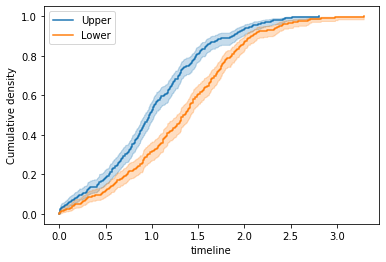

In [ ]:
# Plot the cumulative density (may delete)
km_upper.plot_cumulative_density()
km_lower.plot_cumulative_density()
plt.ylabel('Cumulative density')
plt.show()

# Cox Proportional-Hazards Model

In [ ]:
# Univariate Cox regression analysis using feature x_6:
from lifelines import CoxPHFitter
dataset_uni = dataset[[ 'x_6', 'time', 'event']]

cph_uni = CoxPHFitter()

cph_uni.fit(dataset_uni,"time",event_col="event")
cph_uni.print_summary()

<lifelines.CoxPHFitter: fitted with 1000 total observations, 223 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 1000
number of events observed = 777
   partial log-likelihood = -4405.60
         time fit was run = 2021-06-16 10:16:48 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
x_6         0.07       1.08       0.01             0.05             0.09                 1.06                 1.10

             z      p   -log2(p)
covariate                       
x_6       7.19 <0.005      40.50
---
Concordance = 0.59
Partial AIC = 8813.20
log-likelihood ratio test = 51.99 on 1 df
-log2(p) of ll-ratio test = 40.71

It is shown that in the univariate Cox regression analysis, feature x_6 gives Hazard ratio 1.08, p-value < 0.005 and c-index 0.59. It means that unit increase of x_6 has 8% higher risk of death.

In [ ]:
# Another way to calculate c-index
from lifelines.utils import concordance_index
cph_uni = CoxPHFitter().fit(dataset_uni, 'time', 'event')
concordance_index(dataset_uni['time'], -cph_uni.predict_partial_hazard(dataset_uni), dataset_uni['event'])

0.5911955406800024

In [ ]:
# Multivariate Cox regression analysis:
from lifelines import CoxPHFitter
dataset = dataset[[ 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6','x_7', 'x_8', 'x_9', 'x_10', 'time', 'event']]

cph = CoxPHFitter()

cph.fit(dataset,"time",event_col="event")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1000 total observations, 223 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 1000
number of events observed = 777
   partial log-likelihood = -3606.81
         time fit was run = 2021-06-16 10:17:05 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
x_1         0.30       1.35       0.01             0.27             0.32                 1.31                 1.38
x_2         0.62       1.86       0.03             0.56             0.68                 1.75                 1.97
x_3         0.09       1.10       0.00             0.09             0.10                 1.09                 1.11
x_4         0.13       1.14       0.01             0.12             0.15                 1.13                 1.16
x_5         0.03       1.03       0.00             0.03             0.03                 1.03                 1.03
x_6         0.27       1.31       0.01             0.25             0.30                 1.28                 1.35
x_7         0.11       1.11       0.00             0.10             0.12                 1.10                 1.12
x_8         0.75       2.12       0.03             0.69             0.82                 1.99                 2.27
x_9         0.13       1.14       0.01             0.12             0.15                 1.13                 1.16
x_10        0.29       1.33       0.01             0.26             0.31                 1.30                 1.37

              z      p   -log2(p)
covariate                        
x_1       22.31 <0.005     363.85
x_2       21.29 <0.005     331.60
x_3       21.05 <0.005     324.50
x_4       21.15 <0.005     327.47
x_5       21.42 <0.005     335.66
x_6       21.03 <0.005     323.80
x_7       22.03 <0.005     355.03
x_8       22.11 <0.005     357.45
x_9       19.98 <0.005     292.48
x_10      21.48 <0.005     337.72
---
Concordance = 0.88
Partial AIC = 7233.61
log-likelihood ratio test = 1649.58 on 10 df
-log2(p) of ll-ratio test = inf

In [ ]:
from lifelines.utils import concordance_index
cph = CoxPHFitter().fit(dataset, 'time', 'event')
concordance_index(dataset['time'], -cph.predict_partial_hazard(dataset), dataset['event'])

0.8804835739806081

The p-value for x_8 is <0.005 and HR is 2.12, indicating a strong relationship between the x_8 value and increased risk of death. Holding the other covariates constant, a higher value of x_8 is associated with poor survival. Here person with higher x_8 value has a 112% higher risk of death. 

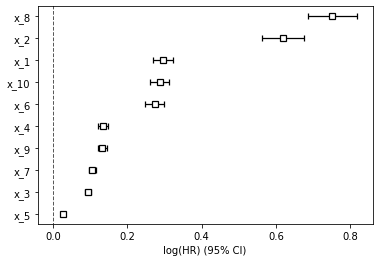

In [ ]:
cph.plot()

Next: Compare subjects’ survival when we vary one covariate and keep all else constant.

Text(0, 0.5, 'Survival probability')

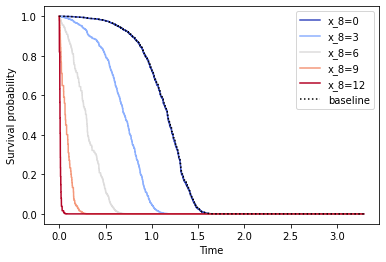

In [ ]:
cph.plot_partial_effects_on_outcome('x_8', values=range(0, 15, 3), cmap='coolwarm')
plt.xlabel('Time')
plt.ylabel('Survival probability')

Next: Use the first 5 subjects to observe the influence of features on the survival curve.

In [ ]:
dataset.head()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,time,event
0,1.475876,-1.776096,4.915642,122.0,98.094698,5.972386,1.660803,-1.864064,118.0,7.660347,0.000000,0.0
1,6.962669,-1.252591,19.444990,111.0,-8.769640,8.096565,23.921275,-0.451359,131.0,-1.836969,0.000000,0.0
2,4.974584,-1.443488,-2.923769,109.0,69.898629,5.883239,11.301937,-3.209809,132.0,0.825555,2.149633,1.0
3,6.565848,-0.209302,15.752279,118.0,-9.126213,7.206371,15.295552,-1.707323,117.0,2.551161,1.311286,1.0
4,8.185607,0.997027,8.567676,119.0,24.094598,7.853565,12.516080,-0.047749,127.0,6.001835,0.215496,1.0


Text(0, 0.5, 'Survival probability')

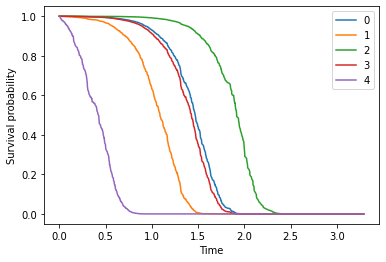

In [ ]:
# Plot the survival probability of the first 5 patients
d_data = dataset.iloc[0:5,:]
cph.predict_survival_function(d_data).plot()
plt.xlabel('Time')
plt.ylabel('Survival probability')

Subject 2 who has low x_8 value has higher survival rate comparing with other subjects. 

# Use the partial hazard (risk score) from fitted Cox model as new feature for patient stratification

In [ ]:
# Stratified Split based on the 'event' column
from sklearn.model_selection import StratifiedShuffleSplit

# Create the splitting object
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Apply the split to the data frame using the "diagnosis" column as our label
for train_index, test_index in split.split(dataset, dataset["event"]):
    Training_set = dataset.iloc[train_index]
    Test_set = dataset.iloc[test_index]

In [ ]:
# Fit the CoxPH model on the discovery set, get estimated coefficients
dataset_train = Training_set[[ 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6','x_7', 'x_8', 'x_9', 'x_10', 'time', 'event']]
dataset_test = Test_set[[ 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6','x_7', 'x_8', 'x_9', 'x_10', 'time', 'event']]

cph_train = CoxPHFitter()

cph_train.fit(dataset_train,"time",event_col="event")
cph_train.print_summary()

<lifelines.CoxPHFitter: fitted with 700 total observations, 156 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 700
number of events observed = 544
   partial log-likelihood = -2350.07
         time fit was run = 2021-06-16 10:17:33 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
x_1         0.29       1.34       0.02             0.26             0.32                 1.30                 1.38
x_2         0.62       1.86       0.03             0.55             0.69                 1.73                 1.99
x_3         0.09       1.10       0.01             0.08             0.10                 1.08                 1.11
x_4         0.14       1.15       0.01             0.12             0.15                 1.13                 1.16
x_5         0.03       1.03       0.00             0.03             0.03                 1.03                 1.03
x_6         0.28       1.32       0.02             0.24             0.31                 1.28                 1.36
x_7         0.10       1.11       0.01             0.09             0.12                 1.10                 1.12
x_8         0.75       2.12       0.04             0.67             0.84                 1.95                 2.31
x_9         0.13       1.14       0.01             0.12             0.15                 1.13                 1.16
x_10        0.28       1.32       0.02             0.25             0.31                 1.28                 1.37

              z      p   -log2(p)
covariate                        
x_1       18.58 <0.005     253.43
x_2       17.80 <0.005     233.02
x_3       17.26 <0.005     219.24
x_4       17.76 <0.005     232.11
x_5       18.34 <0.005     247.22
x_6       17.46 <0.005     224.37
x_7       18.11 <0.005     241.18
x_8       17.46 <0.005     224.37
x_9       16.71 <0.005     205.91
x_10      17.90 <0.005     235.69
---
Concordance = 0.88
Partial AIC = 4720.13
log-likelihood ratio test = 1123.57 on 10 df
-log2(p) of ll-ratio test = 778.52

In [ ]:
# Generate partial hazard as the new feature on both discovery and validation sets
partial_hazard_train = cph_train.predict_partial_hazard(dataset_train)
partial_hazard_test = cph_train.predict_partial_hazard(dataset_test)

In [ ]:
partial_hazard_train.describe()

count      700.000000
mean       104.704570
std        791.772290
min          0.000035
25%          0.130887
50%          1.017487
75%          7.069013
max      12980.916997
dtype: float64

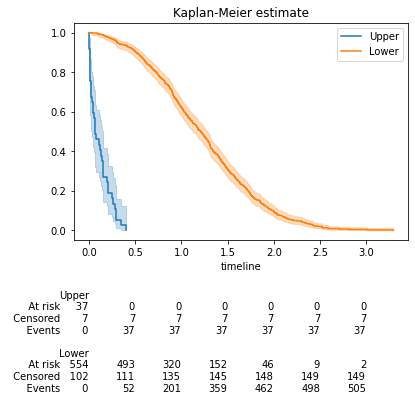

<Figure size 432x288 with 0 Axes>

In [ ]:
# Use mean value in the discovery set as the cut-off value and divide subjects into two groups
cutoff_value = partial_hazard_train.mean()
upper = partial_hazard_train>cutoff_value
T_upper_train = dataset_train['time'][upper]
E_upper_train = dataset_train['event'][upper]
lower = partial_hazard_train<=cutoff_value
T_lower_train = dataset_train['time'][lower]
E_lower_train = dataset_train['event'][lower]
# Initializing the KaplanMeierModel for each group
km_upper = KaplanMeierFitter()
km_lower = KaplanMeierFitter()

# Fitting the model 
T = dataset_train['time'].values
E = dataset_train['event'].values
ax = plt.subplot(111)
ax = km_upper.fit(T_upper_train, event_observed=E_upper_train, label = 'Upper').plot_survival_function(ax=ax)
ax = km_lower.fit(T_lower_train, event_observed=E_lower_train, label = 'Lower').plot_survival_function(ax=ax)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(km_upper, km_lower, ax=ax)
plt.title('Kaplan-Meier estimate')
plt.ylabel('Survival probability')
plt.show()
plt.tight_layout()

In [ ]:
# Log-rank test: if there is any significant difference between the groups being compared
from lifelines.statistics import logrank_test
results = logrank_test(T_lower_train, T_upper_train, E_lower_train, E_upper_train)
# print metrics
print("p-value on the discovery set %s; log-rank %s" % (results.p_value, np.round(results.test_statistic, 6)))

p-value on the discovery set 4.4027704944468596e-170; log-rank 772.810268


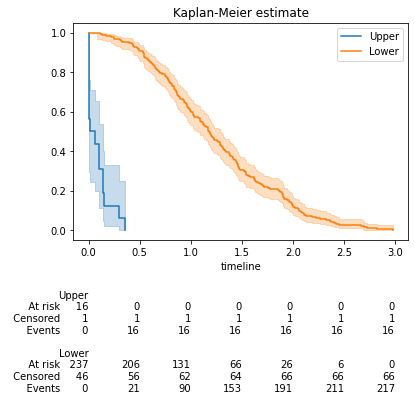

<Figure size 432x288 with 0 Axes>

In [ ]:
# Use mean value in the discovery set as the cut-off value and divide subjects int the validation set into two groups
upper = partial_hazard_test>cutoff_value
T_upper_test = dataset_test['time'][upper]
E_upper_test = dataset_test['event'][upper]
lower = partial_hazard_test<=cutoff_value
T_lower_test = dataset_test['time'][lower]
E_lower_test = dataset_test['event'][lower]
# Initializing the KaplanMeierModel for each group
km_upper = KaplanMeierFitter()
km_lower = KaplanMeierFitter()

# Fitting the model 
T = dataset_test['time'].values
E = dataset_test['event'].values
ax = plt.subplot(111)
ax = km_upper.fit(T_upper_test, event_observed=E_upper_test, label = 'Upper').plot_survival_function(ax=ax)
ax = km_lower.fit(T_lower_test, event_observed=E_lower_test, label = 'Lower').plot_survival_function(ax=ax)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(km_upper, km_lower, ax=ax)
plt.title('Kaplan-Meier estimate')
plt.ylabel('Survival probability')
plt.show()
plt.tight_layout()

In [ ]:
# Log-rank test: if there is any significant difference between the groups being compared
results = logrank_test(T_lower_test, T_upper_test, E_lower_test, E_upper_test)
# print metrics
print("p-value on the validation set %s; log-rank %s" % (results.p_value, np.round(results.test_statistic, 6)))

p-value on the validation set 2.7171909571771865e-80; log-rank 360.071017


In [ ]:
dataset_test['hazard'] = partial_hazard_test
dataset_test = dataset_test[[ 'hazard', 'time', 'event']]
cph = CoxPHFitter().fit(dataset_test, 'time', 'event')
cindex = concordance_index(dataset_test['time'], -cph.predict_partial_hazard(dataset_test), dataset_test['event'])
# print metrics
print("c-index on the validation set %s" % (cindex))

c-index on the validation set 0.8847106268572237


The hazard feature is shown significant in both discovery and validation cohorts. (p-value< 0.005 and c-index around 0.88)